In [1]:
%load_ext autoreload

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

True

In [2]:
%autoreload 2

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import torch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler

from estuary.low_quality.config import QualityConfig
from estuary.util.constants import EIGHT_TO_4
from estuary.util.img import contrast_stretch, false_color, masked_contrast_stretch

In [3]:
# df = pd.read_csv("/Volumes/x10pro/estuary/low_quality/quality_labels.csv")
# df = df[df.cluster_label >= 0]
# df_out = df.copy()
# tbase = Path("/Users/kyledorman/data/estuary/dataset/images/")
# import shutil
# for i, row in df.iterrows():
#     source = Path(row.source_tif)
#     region = source.parents[1].name
#     year = source.parents[3].name
#     month = source.parents[2].name
#     dove = source.parents[5].name
#     target = tbase / dove / "results" / year / month / region / "files" / source.name
#     target.parent.mkdir(exist_ok=True, parents=True)
#     if target.is_dir():
#         shutil.rmtree(target)
#     df_out.loc[i, "source_tif"] = str(target)
#     if target.exists():
#         continue
#     shutil.copy(source, target)

# df_out.to_csv("/Users/kyledorman/data/estuary/dataset/quality_labels.csv", index=False)

In [128]:
a = torch.randint(5, (4, 3, 10, 10))
torch.amin(a, dim=(2, 3), keepdim=True).shape

torch.Size([4, 3, 1, 1])

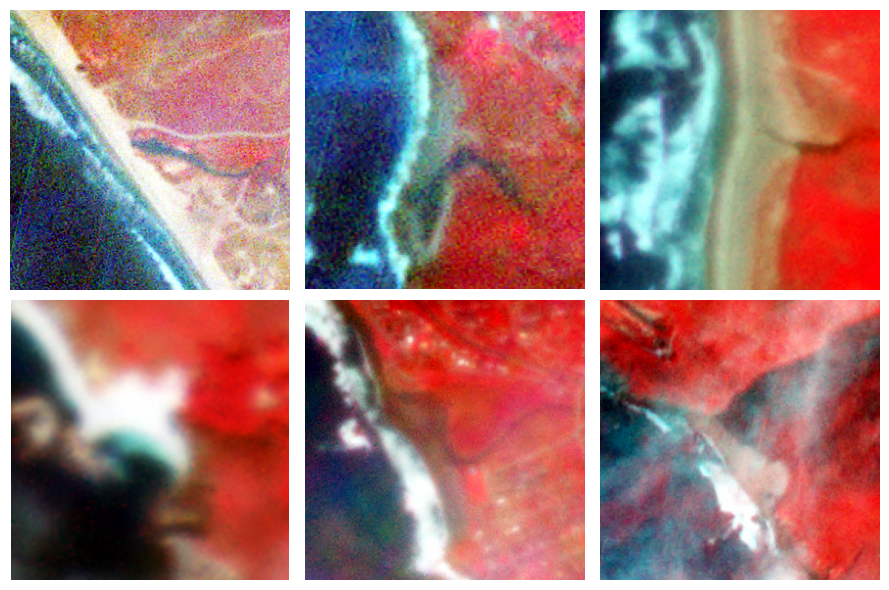

In [360]:
ldf = pd.read_csv("/Users/kyledorman/data/estuary/dataset/low_quality.csv")
ldf = ldf[ldf.label == "unsure"].copy()
index = np.random.choice(len(ldf), 6, replace=False)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))

for i, ax in zip(index, axes.flatten(), strict=False):
    pth = ldf.iloc[i].source_tif
    with rasterio.open(pth) as src:
        data = src.read(out_dtype=np.float32)
        nodata = src.read(1, masked=True).mask
        img = false_color(data, nodata)
    ax.axis("off")
    ax.imshow(img)
fig.tight_layout()
plt.show()

In [4]:
skipped_grids = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].tolist()
print(skipped_grids)

[13, 24, 30, 36, 42, 47, 49, 60, 61, 69, 71, 74, 75, 76, 78, 80, 82, 89, 90, 91, 231]


In [5]:
def asset_id_from_pth(pth):
    return Path(pth).stem.split("_3B")[0]


labels = pd.read_csv("/Users/kyledorman/data/estuary/dataset/low_quality.csv")
labels["asset_id"] = labels.source_tif.apply(asset_id_from_pth)
labels.head(2)

region                                         source_tif   label  \
0      11  /Users/kyledorman/data/estuary/dataset/images/...  unsure   
1      11  /Users/kyledorman/data/estuary/dataset/images/...    open   

              acquired instrument              asset_id  
0  2017-02-10 17:45:58       dove  20170210_174558_0e14  
1  2017-07-01 17:44:21       dove  20170701_174421_100e

In [6]:
with open("/Users/kyledorman/data/estuary/dataset/normalization/stats.json") as f:
    stats = json.load(f)

pt = PowerTransformer(standardize=False)
pt.lambdas_ = np.array(stats["lambdas"])
max_value = pt.transform(np.array([stats["max_raw_pixel_value"]] * 8)[None])[0]
st0 = StandardScaler(with_mean=False)
st0.scale_ = max_value
st = StandardScaler()
st.scale_ = np.array(stats["stds"])
st.mean_ = np.array(stats["means"])

norm = Pipeline([("PowerTransformer", pt), ("StandardScaler0", st0)])

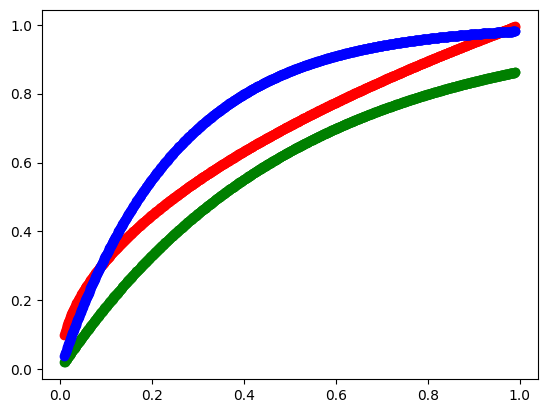

In [13]:
plt.figure()
pts = np.linspace(0.01, 0.99, 1000)
pts0 = np.power(pts, 0.5)
pts1 = 1 - np.exp(pts * -2.0)
pts2 = 1 - np.exp(pts * -4.0)

plt.scatter(x=pts, y=pts0, c="r")
plt.scatter(x=pts, y=pts1, c="g")
plt.scatter(x=pts, y=pts2, c="b")

plt.show()

In [361]:
import kornia.augmentation as K
from kornia.constants import Resample

from estuary.util.transforms import MisalignedImage, RandomPlasmaFog, ScaledRandomGaussianNoise

foggy = K.AugmentationSequential(
    K.RandomSharpness(sharpness=5.0, p=1.0),
    K.RandomPosterize(
        p=1.0,
        bits=(6, 7),
    ),
    ScaledRandomGaussianNoise(
        std=0.05,
        p=1.0,
    ),
    K.RandomPlasmaBrightness(p=1.0, intensity=(0.05, 0.1)),
    RandomPlasmaFog(
        p=1.0,
        fog_intensity=(0.8, 1.0),
        roughness=(0.5, 0.6),
    ),
)

foggy_color = K.AugmentationSequential(
    K.RandomPosterize(
        p=1.0,
        bits=(7, 7),
    ),
    RandomPlasmaFog(
        p=1.0,
        fog_intensity=(0.2, 0.2),
        roughness=(0.5, 0.7),
    ),
    K.RandomPlasmaBrightness(p=1.0, intensity=(0.6, 0.6), roughness=(0.5, 0.5)),
)

blur = K.AugmentationSequential(
    K.RandomMotionBlur(
        kernel_size=9,
        angle=35,
        direction=0.5,
        border_type=2,
        p=1.0,
    ),
    K.RandomGaussianBlur(
        kernel_size=7,
        sigma=(1.0, 3.0),
        p=1.0,
    ),
    K.RandomBoxBlur(
        kernel_size=(7, 7),
        p=1.0,
    ),
    random_apply=1,
)


hazy_blur = K.AugmentationSequential(
    blur,
    RandomPlasmaFog(
        p=1.0,
        fog_intensity=(1.0, 1.0),
        roughness=(0.5, 0.6),
    ),
)

iso_noise = K.AugmentationSequential(
    blur,
    K.RandomGaussianNoise(
        std=0.15,
        p=1.0,
    ),
)

mmm = K.AugmentationSequential(
    MisalignedImage(
        p=1.0, angle_deg=(-35.0, 35.0), edge_shift=(-10, 10), offset=(-20, 20), border_crop=30
    ),
    K.Resize(size=(256, 256), resample=Resample.BICUBIC, antialias=True),
)

illumination = K.AugmentationSequential(
    # K.RandomLinearIllumination(p=1.0, gain=(0.5, 0.9), sign=(0, 1)),  # type: ignore
    K.RandomLinearCornerIllumination(p=1.0, gain=(0.6, 0.8)),  # type: ignore
    random_apply=1,
)

augs = [
    K.Resize(size=(256, 256), resample=Resample.BICUBIC, antialias=True),
    K.AugmentationSequential(
        mmm,
        iso_noise,
        hazy_blur,
        foggy_color,
        foggy,
        random_apply=1,
    ),
]
transforms = K.AugmentationSequential(*augs)

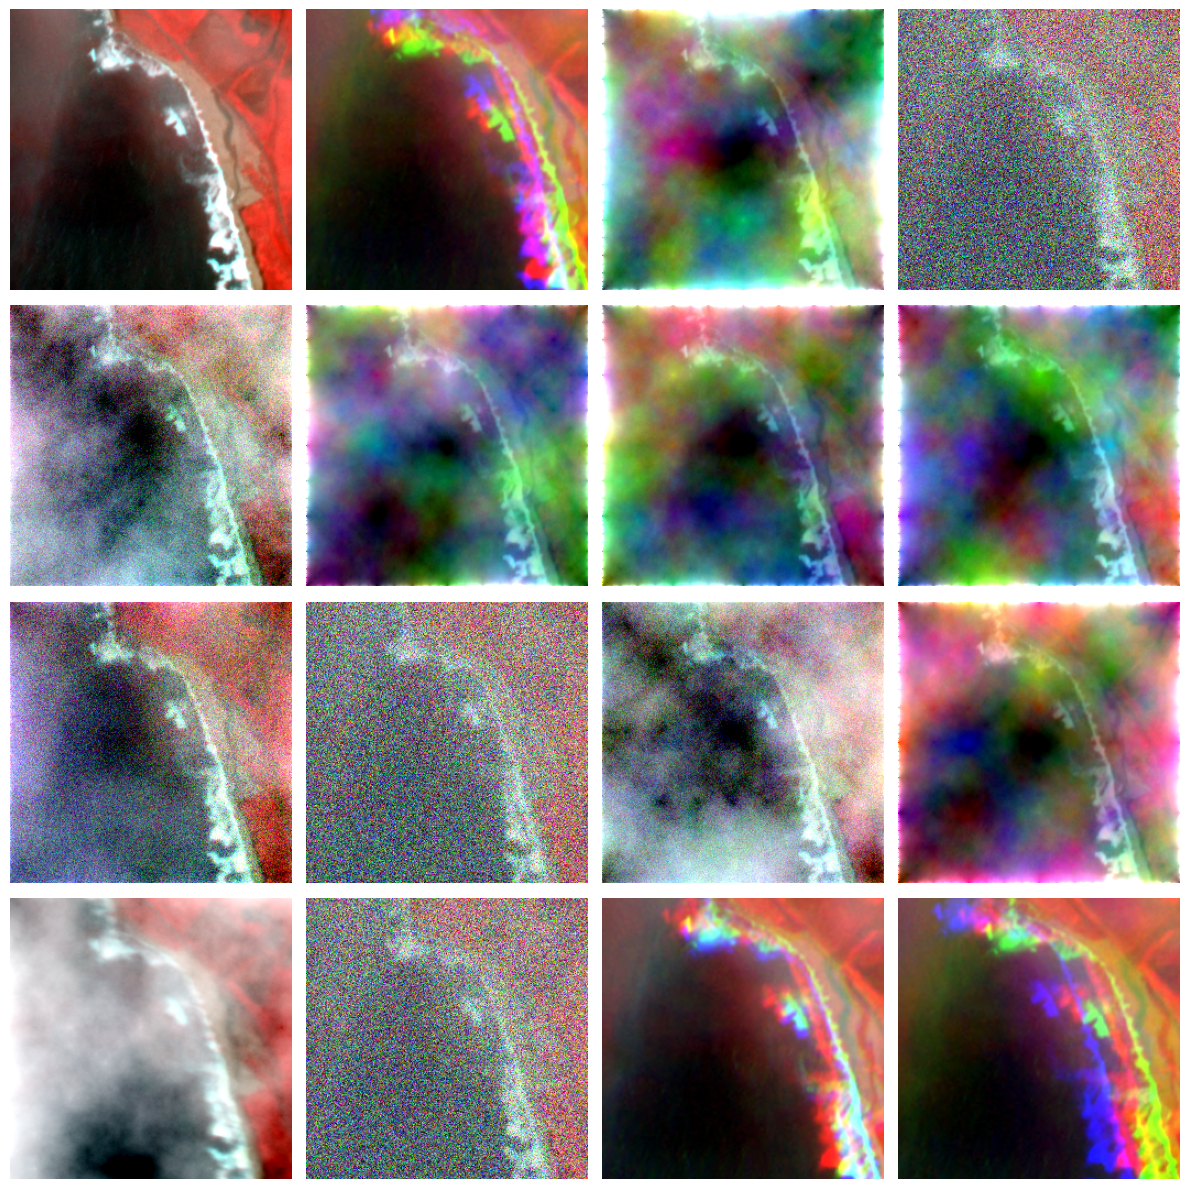

In [363]:
index = np.random.choice(labels[labels.label == "open"].index, 1, replace=False)[0]
row = labels.loc[index]
pth = row.source_tif
with rasterio.open(pth) as src:
    data = src.read(out_dtype=np.float32)
    nodata = src.read(1, masked=True).mask

if len(data) == 4:
    img_data = np.zeros((8, *data.shape[1:]), dtype=data.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img_data[b] = data[i]
else:
    img_data = data

shp = img_data.shape
img_data_norm = norm.transform(img_data.reshape(len(img_data), -1).T).T.reshape(shp)[[7, 5, 3]]
pixels = torch.from_numpy(img_data_norm.astype(np.float32))

nrows = 4
ncols = 4
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(3 * ncols, 3 * nrows))

for i, ax in enumerate(axes.flatten()):
    if i:
        aug_img = transforms(pixels).numpy()[0]
        img = contrast_stretch(aug_img).transpose((1, 2, 0))
    else:
        img = contrast_stretch(img_data_norm).transpose((1, 2, 0))

    ax.axis("off")
    ax.imshow(img)

fig.tight_layout()
plt.show()

In [326]:
def which_aug_ran(aug_seq: K.AugmentationSequential):
    """
    Inspect child modules of an AugmentationSequential and return
    a list of (name, mask) where mask is a boolean tensor of shape (B,)
    indicating which batch items had this aug applied.
    """
    applied = []
    for name, m in aug_seq.named_children():
        p = getattr(m, "_params", None)
        if p is not None and isinstance(p, dict) and ("batch_prob" in p):
            mask = p["batch_prob"].detach().to("cpu").bool()  # (B,)
            applied.append((name, mask))
        # Recurse into nested containers (if you nest AugmentationSequentials)
        elif isinstance(m, K.AugmentationSequential):
            for sub_name, sub_mask in which_aug_ran(m):
                applied.append((f"{name}.{sub_name}", sub_mask))
    return applied

[('Resize_0', tensor([True])),
 ('AugmentationSequential_1.AugmentationSequential_0.MisalignedImage_0',
  tensor([True])),
 ('AugmentationSequential_1.AugmentationSequential_0.Resize_1',
  tensor([True])),
 ('AugmentationSequential_1.AugmentationSequential_1.AugmentationSequential_0.RandomGaussianBlur_1',
  tensor([True])),
 ('AugmentationSequential_1.AugmentationSequential_1.AugmentationSequential_0.RandomBoxBlur_2',
  tensor([True])),
 ('AugmentationSequential_1.AugmentationSequential_1.RandomGaussianNoise_1',
  tensor([True]))]

In [10]:
# fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
# unsure_time_series = time_series_labels[time_series_labels.label == "unsure"]
# for ax in axes.flatten():
#     idx = np.random.choice(list(range(len(unsure_time_series))))
#     row = unsure_time_series.iloc[idx]
#     pth = row.source_tif

#     with rasterio.open(pth) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask

#     if len(data) == 4:
#         img_data = np.zeros((8, *data.shape[1:]), dtype=data.dtype)
#         for i, b in enumerate(reversed(EIGHT_TO_4)):
#             img_data[b] = data[i]
#     else:
#         img_data = data

#     shp = img_data.shape
#     img_data = norm.transform(img_data.reshape(len(img_data), -1).T).T.reshape(shp)

#     ax.axis('off')
#     img = masked_contrast_stretch(img_data[[7, 5, 3]], ~nodata).transpose((1, 2, 0)).clip(0, 1)
#     ax.imshow(img)

# fig.tight_layout()
# plt.show()

In [11]:
from estuary.low_quality.clouds import simulate_clouds

row = merged[merged.label == "open"].iloc[1000]
pth = row.source_tif_x
with rasterio.open(pth) as src:
    data0 = src.read(out_dtype=np.float32)
    nodata0 = src.read(1, masked=True).mask

if len(data0) == 4:
    img_data0 = np.zeros((8, *data0.shape[1:]), dtype=data0.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img_data0[b] = data0[i]
else:
    img_data0 = data0

shp = img_data0.shape
img_data0 = norm.transform(img_data0.reshape(len(img_data0), -1).T).T.reshape(shp)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

rng = np.random.RandomState(0)
for ax in axes.flatten():
    sun_shift_x = int(rng.random() * 40 - 20)
    sun_shift_y = int(rng.random() * 40 - 20)
    img = simulate_clouds(
        img_data0[[7, 5, 3]].transpose((1, 2, 0)),
        rng=rng,
        coverage=rng.random() * 0.5 + 0.3,
        softness=rng.random() * 0.6 + 0.2,
        cloud_brightness=rng.random() * 0.1 + 0.9,
        shadow_strength=rng.random() * 0.3 + 0.1,
        sun_shift=(sun_shift_y, sun_shift_x),
        cloud_tint=(
            rng.random() * 0.2 + 0.8,
            rng.random() * 0.1 + 0.9,
            rng.random() * 0.05 + 0.95,
        ),
        transparency_range=(rng.random() * 0.4 + 0.6, 1.0),
        # hole_coverage=rng.random() * 0.1 + 0.0,
        hole_softness=rng.random() * 8 + 1.0,
        alpha_scale=rng.random() * 0.2 + 0.8,
        edge_feather_power=rng.random() * 0.6 + 0.9,
    ).transpose((2, 0, 1))
    ax.axis("off")
    img = masked_contrast_stretch(img, ~nodata0).transpose((1, 2, 0)).clip(0, 1)
    ax.imshow(img)

fig.tight_layout()
plt.show()

NameError: name 'merged' is not defined

In [ ]:
from estuary.low_quality.clouds import simulate_clouds

img_data = np.zeros((256, 256, 3), dtype=np.float32)
nodata = np.ones((256, 256), dtype=np.uint8)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

rng = np.random.RandomState(0)
for ax in axes.flatten():
    sun_shift_x = int(rng.random() * 40 - 20)
    sun_shift_y = int(rng.random() * 40 - 20)
    img = simulate_clouds(
        img_data,
        rng=rng,
        coverage=rng.random() * 0.2 + 0.7,
        softness=rng.random() * 0.6 + 0.2,
        cloud_brightness=rng.random() * 0.1 + 0.9,
        shadow_strength=rng.random() * 0.3 + 0.1,
        sun_shift=(sun_shift_y, sun_shift_x),
        cloud_tint=(
            rng.random() * 0.3 + 0.7,
            rng.random() * 0.3 + 0.7,
            rng.random() * 0.3 + 0.7,
        ),
        transparency_range=(rng.random() * 0.4 + 0.6, 1.0),
        # hole_coverage=rng.random() * 0.1 + 0.0,
        hole_softness=rng.random() * 8 + 1.0,
        alpha_scale=rng.random() * 0.2 + 0.8,
        edge_feather_power=rng.random() * 0.6 + 0.9,
    )  # .transpose((2, 0, 1))
    ax.axis("off")
    # img = masked_contrast_stretch(img, ~nodata).transpose((1, 2, 0)).clip(0, 1)
    ax.imshow(img)

fig.tight_layout()
plt.show()

In [ ]:
import cv2
from estuary.low_quality.clouds import add_iso_noise, simulate_haze

row = merged[merged.label == "open"].iloc[1000]
pth = row.source_tif_x
with rasterio.open(pth) as src:
    data0 = src.read(out_dtype=np.float32)
    nodata0 = src.read(1, masked=True).mask

if len(data0) == 4:
    img_data = np.zeros((8, *data0.shape[1:]), dtype=data0.dtype)
    for i, b in enumerate(reversed(EIGHT_TO_4)):
        img_data[b] = data0[i]
else:
    img_data = data0

shp = img_data.shape
img_data = (
    norm.transform(img_data.reshape(len(img_data), -1).T)
    .T.reshape(shp)[[7, 5, 3]]
    .transpose((1, 2, 0))
)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))

rng = np.random.RandomState(0)
H, W, _ = img_data.shape
for ax in axes.flatten():
    kernel_size = max(3, H // 50)
    img_data0 = cv2.blur(img_data, (kernel_size, kernel_size))
    img_data0 = add_iso_noise(img_data0, rng, read_noise_std_dev=0.01, scale=5000)
    img_data0 = simulate_haze(
        img_data0,
        rng=rng,
        beta=rng.random() * 0.4 + 2.5,
        strength=1.0,  # rng.random() * 0.05 + 0.95,
    )

    img = img_data0.transpose((2, 0, 1))
    ax.axis("off")
    img = masked_contrast_stretch(img, ~nodata0).transpose((1, 2, 0)).clip(0, 1)
    ax.imshow(img)

fig.tight_layout()
plt.show()

In [ ]:
config = QualityConfig(
    data="/Volumes/x10pro/estuary/low_quality/quality_labels.csv",
    test_data="/Users/kyledorman/data/estuary/dataset/labels.csv",
    normalization_path="/Users/kyledorman/data/estuary/dataset/normalization/stats.json",
    channel_shift_p=0,
    sharpness_p=0,
    brightness_p=0,
    contrast_p=0,
    rotation_p=0,
    vertical_flip_p=0,
    horizontal_flip_p=0,
)

In [ ]:
from estuary.low_quality.data import LowQualityDataset, create_splits

train_df, val_df, test_df = create_splits(config)

ds = LowQualityDataset(train_df, config, True)

In [ ]:
contrast_stretch(img).transpose((1, 2, 0)).shape

In [ ]:
img.shape

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax in axes.flatten():
    idx = np.random.choice(len(ds))
    ax.axis("off")
    data = ds[idx]
    norm_type = data["norm_type"]
    img = data["image"].numpy()
    ax.imshow(contrast_stretch(img).transpose((1, 2, 0)))
    ax.set_title("Good" if data["label"].numpy().item() == 0 else "Bad" + f" {norm_type}")

fig.tight_layout()
plt.show()